## Script #1: Read UCRM4 FOIA HAA Data and Calculate Metrics
__Author__: Billy Raseman

__Purpose__: read in species-level occurrence data from the UCMR4 dataset, combine with "dimension table" (contains metadata about individual HAAs, such as group, CHO cytotoxicity, and molecular weight) and calculate the following: 
- Group-level occurrence for HAA5, HAA6Br, HAA9, mHAA, dHAA, and tHAA
- Group-level CAT (cytotoxicity index)
- Group-level BSF (bromide substition factors)

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

### User inputs

In [2]:
# File paths (relative to /python folder)

## Information about HAA species
dim_path = r'.\data\haa9_dimension_table.csv'  # dimension table for HAA9

## UCMR 4 FOIA data
AtoF_path = r'.\data\UCMR4 FOIA\NCOD_UCMR4_QHS_220103_A to F.xlsx'
GtoM_path = r'.\data\UCMR4 FOIA\NCOD_UCMR4_QHS_220103_G to M.xlsx'
NtoP_path = r'.\data\UCMR4 FOIA\NCOD_UCMR4_QHS_220103 N to P.xlsx'
RtoW_path = r'.\data\UCMR4 FOIA\NCOD_UCMR4_QHS_220103 R to W.xlsx'
foia_files = [AtoF_path, GtoM_path, NtoP_path, RtoW_path]

## Output paths
out_ocr_path = r'.\output\foia_species_occur.csv'
out_ocrplus_path = r'.\output\foia_species_occur_CAT_molarconc.csv'
out_grp_path = r'.\output\foia_grp_occur_CAT_molarc_BSF.csv'

# Calculation assumptions
value_belowMRL = 0  # assume that any non-detects are equivalent to zero ug/L

# MRLs (ug/L) for EPA 552.3
MRL_MBAA = 0.3  
MRL_MCAA = 2.0  

# Exclude MBAA and MCAA?
exclude_mHAAs = False

# MCLs (ug/L)
HAA5_MCL = 60

### Read data

In [3]:
# Read occurrence data
df_ocr = pd.DataFrame()
for f in foia_files:
    data = pd.read_excel(f)
    df_ocr = pd.concat([df_ocr, data])

In [41]:
# Inspect FOIA data
df_ocr.columns

Index(['PWSID', 'PWSName', 'Size', 'FacilityID', 'FacilityName',
       'FacilityWaterType', 'SamplePointID', 'SamplePointName',
       'SamplePointType', 'CollectionDate', 'SampleID', 'Contaminant', 'MRL',
       'MethodID', 'AnalyticalResultsSign', 'AnalyticalResultValue(µg/L)',
       'SampleEventCode', 'MonitoringRequirement', 'Region', 'State',
       'CalculatedResultValue(µg/L)'],
      dtype='object')

In [42]:
df_ocr.describe()

,MRL,AnalyticalResultValue(µg/L),CalculatedResultValue(µg/L)
count,571214.000000,326057.000000,571214.000000
mean,0.711077,4.856141,2.771954
std,0.695119,6.908353,5.746263
min,0.200000,0.200000,0.000000
25%,0.300000,0.940000,0.000000
50%,0.300000,2.360000,0.558000
75%,0.500000,5.682000,2.870000
max,2.000000,246.000000,246.000000


In [43]:
# Read HAA dimension table
df_dim = pd.read_csv(dim_path)

In [44]:
# Inspect dimension table
df_dim.columns

Index(['Contaminant', 'Abbreviation', 'Specific Endpoint', 'LC50 Observations',
       'LC50(mol/L)', 'Assay', '1/LC50(L/mol)', 'HAA5', 'HAA6Br', 'HAA9',
       'Grp_HAA_EPA', 'Grp_HAA_Halogen', 'Bromine_Count',
       'MolecularWeight(g/mol)', 'PubChemID'],
      dtype='object')

### Clean up and transform data
- Determine value for non-detects
- Change data types
- Add DBP abbreviations

In [45]:
# Change data types of columns
df_ocr["CollectionDate"] = pd.to_datetime(df_ocr["CollectionDate"])
df_ocr["FacilityID"] = df_ocr["FacilityID"].astype(str)
df_ocr["Region"] = df_ocr["Region"].astype(str)

In [46]:
# Add DBP abbreviations to the dataset
haa_dict = {
    "monobromoacetic acid": "MBAA",
    "monochloroacetic acid": "MCAA",
    "dibromoacetic acid": "DBAA",
    "dichloroacetic acid": "DCAA",
    "bromochloroacetic acid": "BCAA",
    "tribromoacetic acid": "TBAA",
    "trichloroacetic acid": "TCAA",
    "chlorodibromoacetic acid": "CDBAA",
    "bromodichloroacetic acid": "BDCAA"
}  # chemical compound name and abbreviation dictionary

df_ocr['Abbreviation'] = df_ocr['Contaminant'].map(haa_dict)


In [47]:
# Set value for non-detects based on user input (see top of notebook for that value)
df_ocr["CalculatedResultValue(µg/L)"] = df_ocr.apply(
    lambda x:  x["MRL"]*value_belowMRL if x["AnalyticalResultsSign"] == '<' else x["AnalyticalResultValue(µg/L)"], axis=1)
df_ocr.describe()


,MRL,AnalyticalResultValue(µg/L),CalculatedResultValue(µg/L)
count,571214.000000,326057.000000,571214.000000
mean,0.711077,4.856141,2.771954
std,0.695119,6.908353,5.746263
min,0.200000,0.200000,0.000000
25%,0.300000,0.940000,0.000000
50%,0.300000,2.360000,0.558000
75%,0.500000,5.682000,2.870000
max,2.000000,246.000000,246.000000


In [48]:
# Export HAA species dataset (all files combined and non-detect assumption applied)
df_ocr.to_csv(out_ocr_path, index=False)

### Calculate group-level occurrence and BSF
- EPA regulatory groups: HAA5, HAA6Br, and HAA9
- Halogen-based groups: mHAA, dHAA, and tHAA

In [49]:
# Join HAA fact and dimension table
df_ocr = df_ocr.drop(columns=['Abbreviation'])  # avoid duplication of Abbrevation column
df_haa = pd.merge(left=df_ocr, right=df_dim, on='Contaminant')

In [50]:
# Remove mHAAs from analysis?
if exclude_mHAAs == True:
    df_haa = df_haa[~df_haa['Contaminant'].isin(['monobromoacetic acid', 'monochloroacetic acid'])]

In [51]:
# Calculate molar concentration for each compound: 
df_haa['MolarConc(mol/L)'] = df_haa.apply(
    lambda x: x['CalculatedResultValue(µg/L)'] / (x['MolecularWeight(g/mol)'] * 10**6), axis=1)

In [52]:
# Calculate Calculated Additive Toxicity (CAT) for each compound: 
# - Cytotoxicity Index (CTI) = 1/LC50 * 1000
# - HAA9 CAT = Sum of each HAA9 ([DBP] * CTI), where [DBP] is the molar concentration of a DBP
# required columns: CalculatedResultValue(µg/L), MolecularWeight(g/mol), 1/LC50(L/mol)
df_haa['CAT'] = df_haa.apply(lambda x: x['MolarConc(mol/L)'] * x['1/LC50(L/mol)'] * 10**3, axis=1)

In [53]:
# Export species with molar concentration and CAT included
# df_haa[["PWSID", "FacilityID", "SamplePointID", "SampleEventCode", 'Abbreviation', 'CalculatedResultValue(µg/L)', 'MolarConc(mol/L)', 'CAT']].to_csv("out_ocrplus_path", index=False)
df_haa.to_csv(out_ocrplus_path, index=False)

#### Calculate halogen-based groupings: mHAA, dHAA, and tHAA

In [54]:
df_hal_grp = df_haa.groupby(["PWSID", "FacilityID", "SamplePointID", "SampleEventCode", "Grp_HAA_Halogen"], 
                        as_index=False).agg({'CalculatedResultValue(µg/L)':'sum', 'CAT':'sum'}).rename(columns={'Grp_HAA_Halogen':'Group'})


In [55]:
df_hal_grp.describe()

,CalculatedResultValue(µg/L),CAT
count,190485.000000,190485.000000
mean,8.312355,0.069710
std,10.799407,0.245625
min,0.000000,0.000000
25%,0.000000,0.000000
50%,4.579000,0.022693
75%,13.550000,0.047919
max,349.600000,26.264760


In [56]:
# Prepare for visualizations
hal_grp_order = ['mHAA', 'dHAA', 'tHAA']

C:\Users\WRaseman\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='CAT', ylabel='Proportion'>

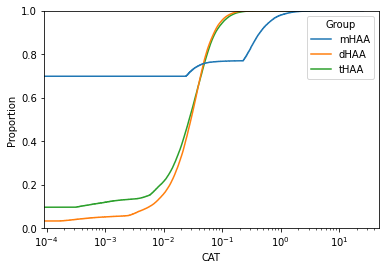

In [57]:
# Visualize mass concentration results
sns.ecdfplot(data=df_hal_grp, x="CAT", hue="Group", hue_order=hal_grp_order, log_scale=True)

C:\Users\WRaseman\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(1.6, 0.4, 'MCAA MRL')

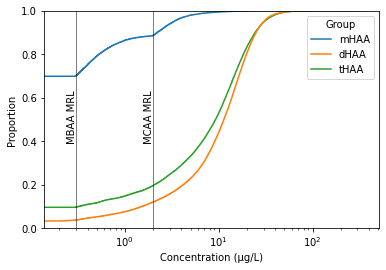

In [58]:
# Visualize mass concentration results
g = sns.ecdfplot(data=df_hal_grp, x="CalculatedResultValue(µg/L)", hue="Group", hue_order=hal_grp_order, log_scale=True)
g.set(xlabel='Concentration (µg/L)')
# Label MRLs
plt.axvline(x=MRL_MBAA, color='black', linewidth=0.5)
plt.text(x=MRL_MBAA - 0.06, y=0.4, s='MBAA MRL', rotation=90)

plt.axvline(x=MRL_MCAA, color='black', linewidth=0.5)
plt.text(x=MRL_MCAA - 0.4, y=0.4, s='MCAA MRL', rotation=90)

#### Calculate EPA's regulatory groupings: HAA5, HAA6Br, HAA9

In [59]:
# HAA5
df_haa5 = df_haa[df_haa['HAA5'] == True]
df_haa5 = df_haa5.groupby(["PWSID", "FacilityID", "SamplePointID", "SampleEventCode"], 
                        as_index=False).agg({'CalculatedResultValue(µg/L)':'sum', 'MolarConc(mol/L)':'sum', 'CAT':'sum'})
df_haa5['Grp_HAA_EPA'] = 'HAA5'


In [60]:
# HAA6Br
df_haa6br = df_haa[df_haa['HAA6Br'] == True]
df_haa6br = df_haa6br.groupby(["PWSID", "FacilityID", "SamplePointID", "SampleEventCode"], 
                        as_index=False).agg({'CalculatedResultValue(µg/L)':'sum', 'CAT':'sum'})
df_haa6br['Grp_HAA_EPA'] = 'HAA6Br'


In [61]:
# HAA9
df_haa9 = df_haa[df_haa['HAA9'] == True]
df_haa9 = df_haa9.groupby(["PWSID", "FacilityID", "SamplePointID", "SampleEventCode"], 
                        as_index=False).agg({'CalculatedResultValue(µg/L)':'sum', 'CAT':'sum'})
df_haa9['Grp_HAA_EPA'] = 'HAA9'


In [62]:
# Combine all of the groups
df_epa_grp = pd.concat([df_haa5, df_haa6br, df_haa9]).reset_index().drop(columns='index').rename(columns={'Grp_HAA_EPA':'Group'})

In [64]:
df_epa_grp[df_epa_grp['Group'] == 'HAA9'].to_csv(r"./output/HAA9-grp_CAT_all-sampling-locs_UMCR4-FOIA.csv", index=False)

In [65]:
# Prepare for visualizations
# epa_grp_order = ['HAA5', 'HAA6Br', 'HAA9']
epa_grp_order = ['HAA5', 'HAA9']

C:\Users\WRaseman\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='CAT', ylabel='Proportion'>

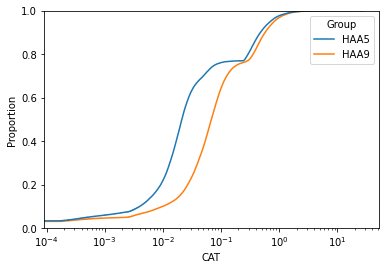

In [66]:
# Visualize CTI
sns.ecdfplot(data=df_epa_grp, x="CAT", hue="Group", hue_order=epa_grp_order, log_scale=True)

C:\Users\WRaseman\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(65, 0.4, 'HAA5 MCL: 60 µg/L')

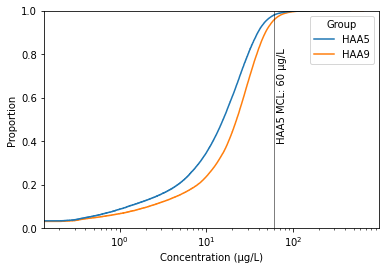

In [67]:
# Visualize mass concentration result
g = sns.ecdfplot(data=df_epa_grp[df_epa_grp['Group'].isin(['HAA5', 'HAA9'])], x="CalculatedResultValue(µg/L)", hue="Group", hue_order=epa_grp_order, log_scale=True)
g.set(xlabel='Concentration (µg/L)')
# Label MCLs
plt.axvline(x=HAA5_MCL, color='black', linewidth=0.5)
plt.text(x=HAA5_MCL + 5, y=0.4, s='HAA5 MCL: 60 µg/L', rotation=90)

(0.95, 1.0)

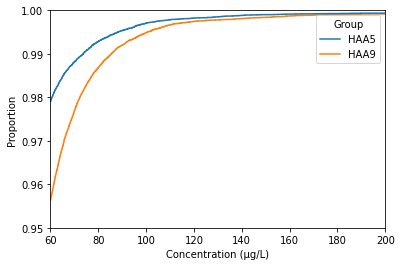

In [68]:
# Visualize mass concentration result
g = sns.ecdfplot(data=df_epa_grp[df_epa_grp['Group'].isin(['HAA5', 'HAA9'])], x="CalculatedResultValue(µg/L)", hue="Group", hue_order=epa_grp_order, log_scale=False)
g.set(xlabel='Concentration (µg/L)')
g.set_xlim([60, 200])
g.set_ylim([0.95, 1])
# Label MCLs
# plt.axvline(x=HAA5_MCL, color='black', linewidth=0.5)
# plt.text(x=HAA5_MCL + 5, y=0.4, s='HAA5 MCL: 60 µg/L', rotation=90)

### Calculate Bromine Substituion Factor (BSF) for mHAA, dHAA, and tHAA

Bromine substitution factor (BSF) for THMs:

<img src="../../img/bsf-thm_hua-and-reckhow-2012_wat-res.png" alt="Bromine subtitution factor equation for THMs" width="400"/>

In this section, a similar equation is applied for HAAs for each group. For example:
- mHAA - BSF : (1 * MBAA) / 1 * (MCAA + MBAA) 
- dHAA - BSF : (1 * BCAA + 2 * DBAA) / 2 * (DCAA + BCAA + DBAA)
- tHAA - BSF : (1 * BDCAA + 2 * DBCAA + 3 * TBAA) / 3 * (TCAA + BDCAA + DBCAA + TBAA)

In [69]:
df_bsf = df_haa[['PWSID', 'FacilityID', 'SampleEventCode', 'Abbreviation', 'SamplePointID', 'MolarConc(mol/L)', 'Grp_HAA_Halogen', 'Bromine_Count']].rename(columns={'Grp_HAA_Halogen':'Group'})
df_bsf.sort_values('MolarConc(mol/L)').head(10)

,PWSID,FacilityID,SampleEventCode,Abbreviation,SamplePointID,MolarConc(mol/L),Group,Bromine_Count
448245,CA0410006,91803,SEH3,TBAA,0410006013,0.0,tHAA,3
457134,CO0143755,99001,SEH2,TBAA,DBP002,0.0,tHAA,3
457135,CO0143755,99001,SEH3,TBAA,DBP002,0.0,tHAA,3
457136,CO0144005,99001,SEH1,TBAA,DBP001,0.0,tHAA,3
457137,CO0144005,99001,SEH2,TBAA,DBP001,0.0,tHAA,3
457138,CO0144005,99001,SEH3,TBAA,DBP001,0.0,tHAA,3
457139,CO0144005,99001,SEH4,TBAA,DBP001,0.0,tHAA,3
457140,CO0144005,99001,SEH1,TBAA,DBP002,0.0,tHAA,3
457141,CO0144005,99001,SEH2,TBAA,DBP002,0.0,tHAA,3
457142,CO0144005,99001,SEH3,TBAA,DBP002,0.0,tHAA,3


In [70]:
df_bsf['BSF_Demoninator_Scalar'] = df_bsf.apply(lambda x: 1 if x['Group'] == "mHAA" else (2 if x['Group'] == "dHAA" else 3), axis=1)
df_bsf['BSF_Demoninator'] = df_bsf['MolarConc(mol/L)'] * df_bsf['BSF_Demoninator_Scalar']
df_bsf['BSF_Numerator'] = df_bsf['MolarConc(mol/L)'] * df_bsf['Bromine_Count']

In [71]:
df_hal_grp_bsf = df_bsf.groupby(["PWSID", "FacilityID", "SamplePointID", "SampleEventCode", "Group"], 
                        as_index=False).agg({'BSF_Demoninator':'sum', 'BSF_Numerator':'sum'})

In [72]:
df_hal_grp_bsf

,PWSID,FacilityID,SamplePointID,SampleEventCode,Group,BSF_Demoninator,BSF_Numerator
0,010106001,1,D12,SEH1,dHAA,1.152604e-07,9.451101e-08
1,010106001,1,D12,SEH1,mHAA,1.000374e-08,1.000374e-08
2,010106001,1,D12,SEH1,tHAA,4.552726e-08,4.140495e-08
3,010106001,1,D12,SEH2,dHAA,6.867300e-09,6.867300e-09
4,010106001,1,D12,SEH2,mHAA,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
190480,WY5601415,90002,DIS002,SEH3,mHAA,0.000000e+00,0.000000e+00
190481,WY5601415,90002,DIS002,SEH3,tHAA,1.113227e-07,2.806136e-08
190482,WY5601415,90002,DIS002,SEH4,dHAA,1.054794e-07,2.811785e-08
190483,WY5601415,90002,DIS002,SEH4,mHAA,0.000000e+00,0.000000e+00


In [73]:
# Calculate BSF
df_hal_grp_bsf['BSF'] = df_hal_grp_bsf['BSF_Numerator'].divide(df_hal_grp_bsf['BSF_Demoninator'])

In [74]:
df_hal_grp_bsf.describe()

,BSF_Demoninator,BSF_Numerator,BSF
count,1.904850e+05,1.904850e+05,138096.000000
mean,1.275139e-07,1.524916e-08,0.247417
std,1.715526e-07,2.798291e-08,0.297717
min,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.048512
50%,6.359744e-08,6.920814e-09,0.121807
75%,2.067339e-07,2.062969e-08,0.306480
max,4.989904e-06,1.896305e-06,1.000000


[Text(0.5, 0, 'Bromine Substitution Factor (BSF)')]

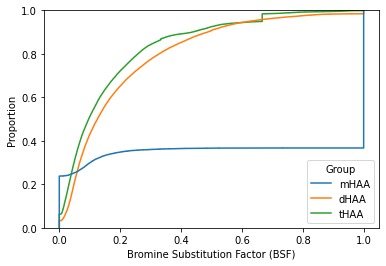

In [75]:
# Visualize mass concentration results
g = sns.ecdfplot(data=df_hal_grp_bsf, x="BSF", hue="Group", hue_order=hal_grp_order, log_scale=False)
g.set(xlabel='Bromine Substitution Factor (BSF)')

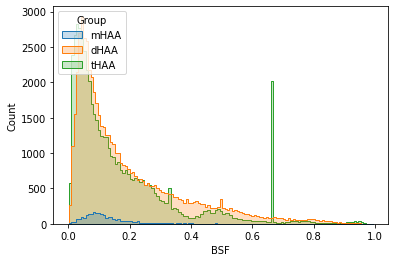

In [76]:
# Visualize BSF results (remove 0 values for log-transformation)
# Note: BSF values = 1 were removed from the record because that is an artifact of non-detects (mostly for mHAA)
df_hal_grp_bsf_notzero = df_hal_grp_bsf[df_hal_grp_bsf['BSF'] > 0]  # remove values of 0
df_hal_grp_bsf_notzero = df_hal_grp_bsf_notzero[df_hal_grp_bsf_notzero['BSF'] != 1]  # remove values of 0
g = sns.histplot(data=df_hal_grp_bsf_notzero, x="BSF", hue="Group", hue_order=hal_grp_order, element="step")
sns.move_legend(g, "upper left")

In [77]:
df_hal_grp_bsf.head()

,PWSID,FacilityID,SamplePointID,SampleEventCode,Group,BSF_Demoninator,BSF_Numerator,BSF
0,010106001,1,D12,SEH1,dHAA,1.152604e-07,9.451101e-08,0.819978
1,010106001,1,D12,SEH1,mHAA,1.000374e-08,1.000374e-08,1.000000
2,010106001,1,D12,SEH1,tHAA,4.552726e-08,4.140495e-08,0.909454
3,010106001,1,D12,SEH2,dHAA,6.867300e-09,6.867300e-09,1.000000
4,010106001,1,D12,SEH2,mHAA,0.000000e+00,0.000000e+00,NaN


### Export results

In [78]:
# Combine and export HAA group data
df_hal_grp_bsf2 = df_hal_grp_bsf[['PWSID', 'FacilityID', 'SamplePointID', 'SampleEventCode', 'Group', 'BSF']]
df_hal_grp_export = pd.merge(left=df_hal_grp, right=df_hal_grp_bsf2, on=['PWSID', 'FacilityID', 'SamplePointID', 'SampleEventCode', 'Group'])
df_grp_export = pd.concat([df_epa_grp, df_hal_grp_export]).reset_index().drop(columns='index')
df_grp_export.to_csv(out_grp_path, index=False)